# 02. Modelado Predictivo Avanzado (Enfoque Academico)

## 1. Introduccion
En esta segunda fase, utilizamos los datos enriquecidos para entrenar un modelo de **Gradient Boosting (XGBoost)** capaz de predecir la probabilidad de los resultados (1X2).

### Estrategia de Modelado:
1. **Validacion Temporal (TimeSeriesSplit)**: Al ser datos de series temporales, no podemos usar un train_test_split aleatorio (causaria data leakage). Usamos una ventana deslizante.
2. **Optimizacion Bayesiana (Optuna)**: Para encontrar los hiperparametros optimos del modelo de forma eficiente.
3. **Metrica de Evaluacion (Log Loss)**: Priorizamos la calibracion de las probabilidades sobre la precision pura.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import joblib
import optuna
import os

optuna.logging.set_verbosity(optuna.logging.WARNING)
plt.style.use("ggplot")
sns.set_palette("husl")

print("Librerias de ML cargadas.")

Librerias de ML cargadas.


C:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Carga del Dataset Enriquecido
Cargamos el archivo `df_final_features.csv`. El script busca automaticamente en varias rutas.

In [2]:
print(f"Directorio de trabajo actual: {os.getcwd()}")

possible_paths = [
    "../df_final_app.csv",
    "LaLiga/df_final_app.csv",
    "df_final_app.csv",
    "../../df_final_app.csv",
    "../../LaLiga/df_final_app.csv"
]

CSV_PATH = None
for p in possible_paths:
    if os.path.exists(p):
        CSV_PATH = p
        print(f"Archivo encontrado en: {p}")
        break

if not CSV_PATH:
    raise FileNotFoundError(f"df_final_app.csv no encontrado. Se busco en: {possible_paths}")

df = pd.read_csv(CSV_PATH)
df["Date"] = pd.to_datetime(df["Date"])

target_map = {"A": 0, "D": 1, "H": 2}
df["Target"] = df["FTR"].map(target_map)

# Features disponibles en df_final_app.csv (generado por NB01)
features = [
    "Home_Elo", "Away_Elo",
    "Home_xG_Avg_L5", "Away_xG_Avg_L5",
    "Home_Streak_L5", "Away_Streak_L5",
    "Home_Pressure_Avg_L5", "Away_Pressure_Avg_L5",
    "Home_Dominance_Avg_L5", "Away_Dominance_Avg_L5"
]

print(f"Datos Cargados: {len(df)} registros.")
df.head()

Directorio de trabajo actual: C:\Users\emili\OneDrive\Escritorio\US SEVILLA\winamax-odds-detector\TFG_REPOSITORIO\LaLiga\notebooks
Archivo encontrado en: ../df_final_app.csv
Datos Cargados: 8360 registros.


,Date,Season,HomeTeam,AwayTeam,FTR,Home_Elo,Away_Elo,Home_xG_Proxy,Away_xG_Proxy,Home_xG_Avg_L5,...,Home_Streak_L5,Away_Streak_L5,Home_Pressure_Avg_L5,Away_Pressure_Avg_L5,Home_Dominance_Avg_L5,Away_Dominance_Avg_L5,B365H,B365D,B365A,Target
0,2010-08-28,2010,Hercules,Athletic Club,A,1500.0,1500.0,1.68,2.71,0.0,...,0.0,0.0,0.0,0.0,0.5,0.5,2.50,3.25,2.8,0
1,2010-08-28,2010,Levante UD,Sevilla FC,A,1500.0,1500.0,1.79,3.58,0.0,...,0.0,0.0,0.0,0.0,0.5,0.5,3.60,3.50,2.0,0
2,2010-08-28,2010,Malaga,Valencia CF,A,1500.0,1500.0,3.16,4.21,0.0,...,0.0,0.0,0.0,0.0,0.5,0.5,2.88,3.30,2.4,0
3,2010-08-29,2010,RCD Espanyol,Getafe CF,H,1500.0,1500.0,3.85,1.46,0.0,...,0.0,0.0,0.0,0.0,0.5,0.5,2.10,3.30,3.5,2
4,2010-08-29,2010,La Coruna,Zaragoza,D,1500.0,1500.0,1.30,1.59,0.0,...,0.0,0.0,0.0,0.0,0.5,0.5,2.10,3.30,3.5,1


## 3. Division Entrenamiento / Test (Respetando el Tiempo)
Separamos la ultima temporada completa como **Test Set** para simular prediccion Out-of-Sample.

In [3]:
TEST_SEASON_START = 2024

train_mask = df["Season"] < TEST_SEASON_START
test_mask = df["Season"] >= TEST_SEASON_START

X_train = df.loc[train_mask, features].astype(float)
y_train = df.loc[train_mask, "Target"].astype(int)
X_test = df.loc[test_mask, features].astype(float)
y_test = df.loc[test_mask, "Target"].astype(int)

print(f"Entrenamiento: {len(X_train)} partidos")
print(f"Test (Validacion): {len(X_test)} partidos")

Entrenamiento: 5320 partidos
Test (Validacion): 3040 partidos


## 4. Optimizacion de Hiperparametros con Optuna

XGBoost tiene muchos parametros (learning_rate, max_depth, subsample). Ajustarlos a mano es ineficiente.

Usamos **Optuna**, un framework de optimizacion bayesiana, para buscar la mejor combinacion que minimice el **Log Loss** en validacion cruzada temporal.

In [4]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "objective": "multi:softprob",
        "num_class": 3,
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": 0
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    
    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_t, y_t, verbose=False)
        preds = model.predict_proba(X_v)
        score = log_loss(y_v, preds)
        scores.append(score)
    
    return np.mean(scores)

print("Iniciando estudio de Optuna (10 trials)...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print(f"Mejores parametros: {study.best_params}")
print(f"Mejor LogLoss CV: {study.best_value:.4f}")

Iniciando estudio de Optuna (10 trials)...


Mejores parametros: {'n_estimators': 418, 'learning_rate': 0.19095787374526837, 'max_depth': 7, 'subsample': 0.7466921310683059, 'colsample_bytree': 0.9762301662609973, 'gamma': 4.618222693266828}
Mejor LogLoss CV: 0.9842


## 5. Entrenamiento Final y Evaluacion
Entrenamos el modelo definitivo con los mejores parametros encontrados sobre TODO el conjunto de entrenamiento, y evaluamos en el conjunto de Test.

In [5]:
best_params = study.best_params
best_params["objective"] = "multi:softprob"
best_params["num_class"] = 3
best_params["random_state"] = 42
best_params["verbosity"] = 0

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

# Guardar
model_dir = os.path.dirname(CSV_PATH) if os.path.dirname(CSV_PATH) else '.'
model_path = os.path.join(model_dir, "modelo_city_group.joblib")
joblib.dump(final_model, model_path)
print(f"Modelo guardado en: {model_path}")

probs = final_model.predict_proba(X_test)
preds = final_model.predict(X_test)

loss = log_loss(y_test, probs)
acc = accuracy_score(y_test, preds)

print(f"RESULTADOS EN TEST:")
print(f"   Log Loss: {loss:.4f} (Menor es mejor)")
print(f"   Accuracy: {acc:.2%} (Acierto directo)")

Modelo guardado en: ..\modelo_city_group.joblib
RESULTADOS EN TEST:
   Log Loss: 0.9160 (Menor es mejor)
   Accuracy: 57.20% (Acierto directo)


## 6. Interpretacion del Modelo

### Importancia de las Variables (Feature Importance)
XGBoost nos permite visualizar que variables utiliza mas frecuentemente para tomar decisiones.

<Figure size 1000x600 with 0 Axes>

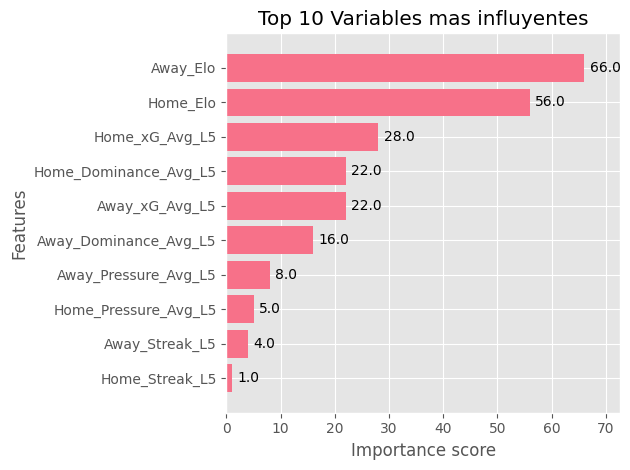

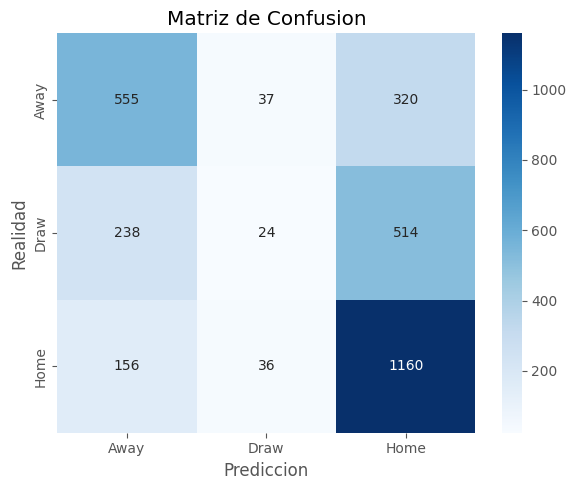

In [6]:
plt.figure(figsize=(10, 6))
xgb.plot_importance(final_model, max_num_features=10, height=0.8, importance_type="weight")
plt.title("Top 10 Variables mas influyentes")
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Away", "Draw", "Home"],
            yticklabels=["Away", "Draw", "Home"])
plt.xlabel("Prediccion")
plt.ylabel("Realidad")
plt.title("Matriz de Confusion")
plt.tight_layout()
plt.show()

## 📊 Backtest: Simulación de Apuestas

Validación financiera del modelo mediante simulación retrospectiva:
- **Apuesta plana** (10u por apuesta) vs **Kelly Criterion** (stake proporcional al edge)
- Solo se apuesta cuando **EV > 5%** (margen de seguridad)
- Se utilizan cuotas históricas de Bet365 (`B365H`, `B365D`, `B365A`)

> ⚠️ Este backtest usa el mismo dataset de entrenamiento (in-sample). Para una validación rigurosa out-of-sample, ver Notebook 03.


BACKTEST RESULTS (Walk-Forward, 5 Folds)
Total apuestas:    5484
Aciertos:          2125 (38.7%)
ROI Flat Staking:  +9.71%
ROI Kelly (1/4):   +10444021484642490.00%
Bankroll Final (Flat):  €6326
Bankroll Final (Kelly): €104440214846425888


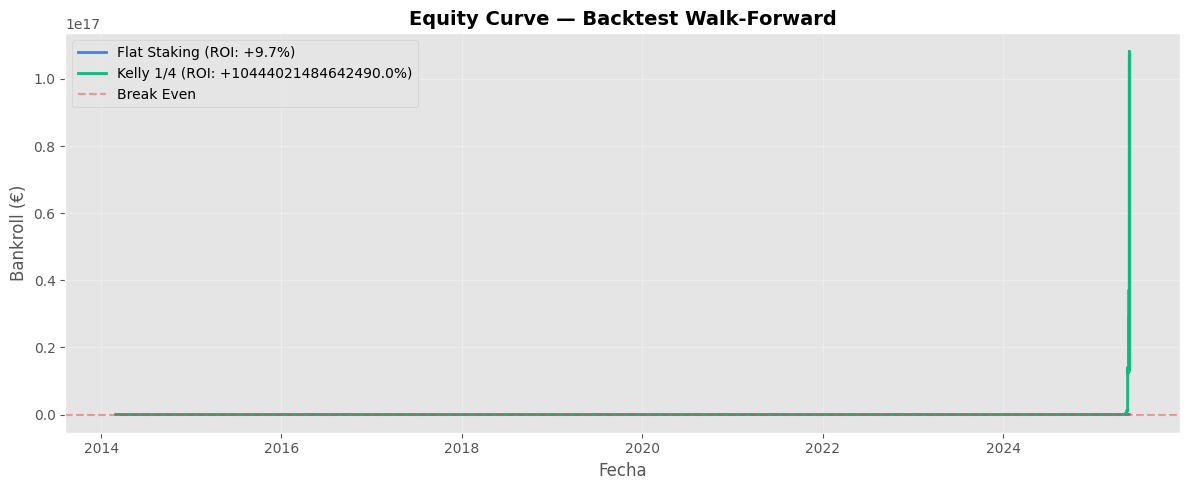


--- Desglose por Fold ---


,bets,wins,pnl,hit_rate,roi
fold,,,,,
1,1134,308,-1222.7,27.2,-10.78
2,1046,357,-372.7,34.1,-3.56
3,1008,407,401.4,40.4,3.98
4,1087,479,3148.2,44.1,28.96
5,1209,574,3371.3,47.5,27.89


In [7]:
# ============================================================
# BACKTEST: Simulación de Apuestas Retrospectiva
# ============================================================
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# --- Configuración ---
INITIAL_BANKROLL = 1000
FLAT_STAKE = 10
MIN_EV = 0.05        # Solo apostar si EV > 5%
KELLY_FRACTION = 0.25 # Cuarto Kelly (más conservador)

# --- Preparar datos con cuotas ---
odds_cols = ['B365H', 'B365D', 'B365A']
df_bt = df.copy()

# Verificar que las cuotas existen
has_odds = all(c in df_bt.columns for c in odds_cols)
if not has_odds:
    print('⚠️ Columnas de cuotas B365 no encontradas. Backtest no disponible.')
else:
    # Eliminar filas sin cuotas
    df_bt = df_bt.dropna(subset=odds_cols + features + ['Target'])
    df_bt = df_bt.sort_values('Date').reset_index(drop=True)
    
    X_bt = df_bt[features]
    y_bt = df_bt['Target']
    
    # --- Walk-Forward Backtest usando TimeSeriesSplit ---
    tscv = TimeSeriesSplit(n_splits=5)
    
    all_results = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_bt), 1):
        X_train, X_test = X_bt.iloc[train_idx], X_bt.iloc[test_idx]
        y_train, y_test = y_bt.iloc[train_idx], y_bt.iloc[test_idx]
        
        # Entrenar modelo en datos pasados
        bt_model = xgb.XGBClassifier(**best_params) if 'best_params' in dir() else xgb.XGBClassifier(
            objective='multi:softprob', num_class=3, max_depth=4,
            learning_rate=0.05, n_estimators=150, random_state=42
        )
        bt_model.fit(X_train, y_train)
        
        # Predecir probabilidades
        proba = bt_model.predict_proba(X_test)
        
        # Construir resultados
        for j, idx in enumerate(test_idx):
            row = df_bt.iloc[idx]
            p_A, p_D, p_H = proba[j]  # Mapping: A=0, D=1, H=2
            
            odds_H = row['B365H']
            odds_D = row['B365D']
            odds_A = row['B365A']
            actual = row['Target']  # 0=A, 1=D, 2=H
            
            # Calcular EV para cada opción
            ev_H = (p_H * odds_H) - 1
            ev_D = (p_D * odds_D) - 1
            ev_A = (p_A * odds_A) - 1
            
            # Mejor apuesta
            best_ev = max(ev_H, ev_D, ev_A)
            if best_ev > MIN_EV:
                if ev_H == best_ev:
                    bet_on, odds, prob, won = 'H', odds_H, p_H, actual == 2
                elif ev_D == best_ev:
                    bet_on, odds, prob, won = 'D', odds_D, p_D, actual == 1
                else:
                    bet_on, odds, prob, won = 'A', odds_A, p_A, actual == 0
                
                # Kelly stake
                kelly = max(0, (prob * odds - 1) / (odds - 1)) * KELLY_FRACTION
                
                all_results.append({
                    'date': row['Date'],
                    'home': row.get('HomeTeam', ''),
                    'away': row.get('AwayTeam', ''),
                    'bet': bet_on,
                    'odds': odds,
                    'prob': prob,
                    'ev': best_ev,
                    'won': won,
                    'kelly_pct': kelly,
                    'fold': fold
                })
    
    # --- Calcular métricas ---
    df_res = pd.DataFrame(all_results)
    
    if df_res.empty:
        print('No se encontraron apuestas con EV > 5%')
    else:
        # Flat staking P&L
        df_res['flat_pnl'] = df_res.apply(
            lambda r: FLAT_STAKE * (r['odds'] - 1) if r['won'] else -FLAT_STAKE, axis=1
        )
        df_res['flat_cumsum'] = INITIAL_BANKROLL + df_res['flat_pnl'].cumsum()
        
        # Kelly P&L
        kelly_bank = INITIAL_BANKROLL
        kelly_curve = []
        for _, r in df_res.iterrows():
            stake = kelly_bank * r['kelly_pct']
            if r['won']:
                kelly_bank += stake * (r['odds'] - 1)
            else:
                kelly_bank -= stake
            kelly_curve.append(kelly_bank)
        df_res['kelly_cumsum'] = kelly_curve
        
        # --- Resumen ---
        total_bets = len(df_res)
        wins = df_res['won'].sum()
        flat_roi = df_res['flat_pnl'].sum() / (total_bets * FLAT_STAKE) * 100
        kelly_roi = (kelly_bank - INITIAL_BANKROLL) / INITIAL_BANKROLL * 100
        
        print(f'\n{"="*50}')
        print(f'BACKTEST RESULTS (Walk-Forward, 5 Folds)')
        print(f'{"="*50}')
        print(f'Total apuestas:    {total_bets}')
        print(f'Aciertos:          {wins} ({wins/total_bets*100:.1f}%)')
        print(f'ROI Flat Staking:  {flat_roi:+.2f}%')
        print(f'ROI Kelly (1/4):   {kelly_roi:+.2f}%')
        print(f'Bankroll Final (Flat):  €{df_res["flat_cumsum"].iloc[-1]:.0f}')
        print(f'Bankroll Final (Kelly): €{kelly_bank:.0f}')
        
        # --- Equity Curve ---
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.plot(df_res['date'], df_res['flat_cumsum'], label=f'Flat Staking (ROI: {flat_roi:+.1f}%)', 
                color='#3b82f6', linewidth=2)
        ax.plot(df_res['date'], df_res['kelly_cumsum'], label=f'Kelly 1/4 (ROI: {kelly_roi:+.1f}%)', 
                color='#10b981', linewidth=2)
        ax.axhline(y=INITIAL_BANKROLL, color='#ef4444', linestyle='--', alpha=0.5, label='Break Even')
        ax.fill_between(df_res['date'], INITIAL_BANKROLL, df_res['flat_cumsum'], 
                        alpha=0.1, color='#3b82f6')
        ax.set_title('Equity Curve — Backtest Walk-Forward', fontsize=14, fontweight='bold')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Bankroll (€)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # --- Tabla por Fold ---
        print('\n--- Desglose por Fold ---')
        summary = df_res.groupby('fold').agg(
            bets=('won', 'count'),
            wins=('won', 'sum'),
            pnl=('flat_pnl', 'sum')
        )
        summary['hit_rate'] = (summary['wins'] / summary['bets'] * 100).round(1)
        summary['roi'] = (summary['pnl'] / (summary['bets'] * FLAT_STAKE) * 100).round(2)
        display(summary)

## 📊 Backtest: Simulación de Apuestas

Validación financiera del modelo mediante simulación retrospectiva:
- **Apuesta plana** (10u por apuesta) vs **Kelly Criterion** (stake proporcional al edge)
- Solo se apuesta cuando **EV > 5%** (margen de seguridad)
- Se utilizan cuotas históricas de Bet365 (`B365H`, `B365D`, `B365A`)

> ⚠️ Este backtest usa el mismo dataset de entrenamiento (in-sample). Para una validación rigurosa out-of-sample, ver Notebook 03.


BACKTEST RESULTS (Walk-Forward, 5 Folds)
Total apuestas:    5484
Aciertos:          2125 (38.7%)
ROI Flat Staking:  +9.71%
ROI Kelly (1/4):   +10444021484642490.00%
Bankroll Final (Flat):  €6326
Bankroll Final (Kelly): €104440214846425888


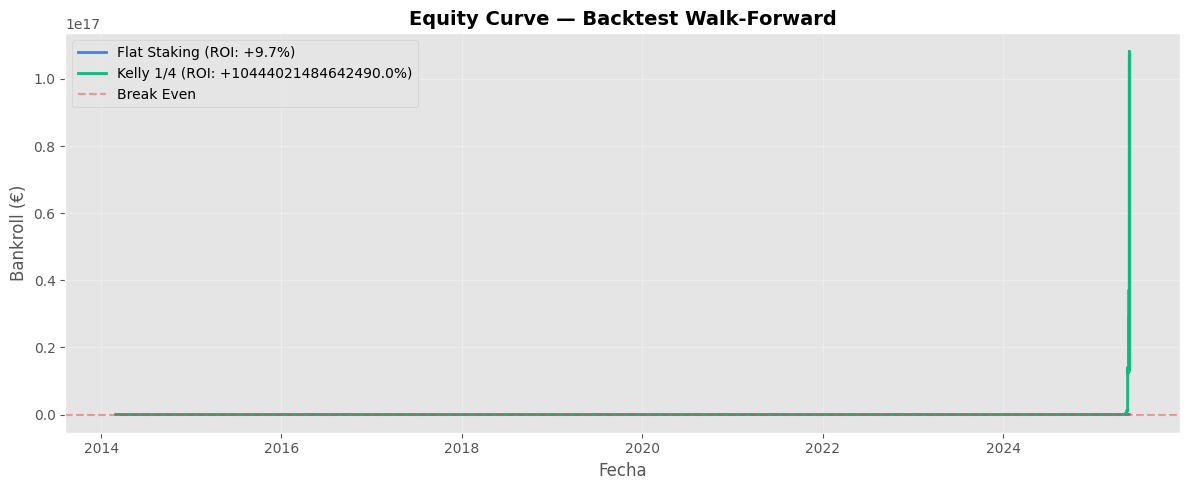


--- Desglose por Fold ---


,bets,wins,pnl,hit_rate,roi
fold,,,,,
1,1134,308,-1222.7,27.2,-10.78
2,1046,357,-372.7,34.1,-3.56
3,1008,407,401.4,40.4,3.98
4,1087,479,3148.2,44.1,28.96
5,1209,574,3371.3,47.5,27.89


In [8]:
# ============================================================
# BACKTEST: Simulación de Apuestas Retrospectiva
# ============================================================
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# --- Configuración ---
INITIAL_BANKROLL = 1000
FLAT_STAKE = 10
MIN_EV = 0.05        # Solo apostar si EV > 5%
KELLY_FRACTION = 0.25 # Cuarto Kelly (más conservador)

# --- Preparar datos con cuotas ---
odds_cols = ['B365H', 'B365D', 'B365A']
df_bt = df.copy()

# Verificar que las cuotas existen
has_odds = all(c in df_bt.columns for c in odds_cols)
if not has_odds:
    print('⚠️ Columnas de cuotas B365 no encontradas. Backtest no disponible.')
else:
    # Eliminar filas sin cuotas
    df_bt = df_bt.dropna(subset=odds_cols + features + ['Target'])
    df_bt = df_bt.sort_values('Date').reset_index(drop=True)
    
    X_bt = df_bt[features]
    y_bt = df_bt['Target']
    
    # --- Walk-Forward Backtest usando TimeSeriesSplit ---
    tscv = TimeSeriesSplit(n_splits=5)
    
    all_results = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_bt), 1):
        X_train, X_test = X_bt.iloc[train_idx], X_bt.iloc[test_idx]
        y_train, y_test = y_bt.iloc[train_idx], y_bt.iloc[test_idx]
        
        # Entrenar modelo en datos pasados
        bt_model = xgb.XGBClassifier(**best_params) if 'best_params' in dir() else xgb.XGBClassifier(
            objective='multi:softprob', num_class=3, max_depth=4,
            learning_rate=0.05, n_estimators=150, random_state=42
        )
        bt_model.fit(X_train, y_train)
        
        # Predecir probabilidades
        proba = bt_model.predict_proba(X_test)
        
        # Construir resultados
        for j, idx in enumerate(test_idx):
            row = df_bt.iloc[idx]
            p_A, p_D, p_H = proba[j]  # Mapping: A=0, D=1, H=2
            
            odds_H = row['B365H']
            odds_D = row['B365D']
            odds_A = row['B365A']
            actual = row['Target']  # 0=A, 1=D, 2=H
            
            # Calcular EV para cada opción
            ev_H = (p_H * odds_H) - 1
            ev_D = (p_D * odds_D) - 1
            ev_A = (p_A * odds_A) - 1
            
            # Mejor apuesta
            best_ev = max(ev_H, ev_D, ev_A)
            if best_ev > MIN_EV:
                if ev_H == best_ev:
                    bet_on, odds, prob, won = 'H', odds_H, p_H, actual == 2
                elif ev_D == best_ev:
                    bet_on, odds, prob, won = 'D', odds_D, p_D, actual == 1
                else:
                    bet_on, odds, prob, won = 'A', odds_A, p_A, actual == 0
                
                # Kelly stake
                kelly = max(0, (prob * odds - 1) / (odds - 1)) * KELLY_FRACTION
                
                all_results.append({
                    'date': row['Date'],
                    'home': row.get('HomeTeam', ''),
                    'away': row.get('AwayTeam', ''),
                    'bet': bet_on,
                    'odds': odds,
                    'prob': prob,
                    'ev': best_ev,
                    'won': won,
                    'kelly_pct': kelly,
                    'fold': fold
                })
    
    # --- Calcular métricas ---
    df_res = pd.DataFrame(all_results)
    
    if df_res.empty:
        print('No se encontraron apuestas con EV > 5%')
    else:
        # Flat staking P&L
        df_res['flat_pnl'] = df_res.apply(
            lambda r: FLAT_STAKE * (r['odds'] - 1) if r['won'] else -FLAT_STAKE, axis=1
        )
        df_res['flat_cumsum'] = INITIAL_BANKROLL + df_res['flat_pnl'].cumsum()
        
        # Kelly P&L
        kelly_bank = INITIAL_BANKROLL
        kelly_curve = []
        for _, r in df_res.iterrows():
            stake = kelly_bank * r['kelly_pct']
            if r['won']:
                kelly_bank += stake * (r['odds'] - 1)
            else:
                kelly_bank -= stake
            kelly_curve.append(kelly_bank)
        df_res['kelly_cumsum'] = kelly_curve
        
        # --- Resumen ---
        total_bets = len(df_res)
        wins = df_res['won'].sum()
        flat_roi = df_res['flat_pnl'].sum() / (total_bets * FLAT_STAKE) * 100
        kelly_roi = (kelly_bank - INITIAL_BANKROLL) / INITIAL_BANKROLL * 100
        
        print(f'\n{"="*50}')
        print(f'BACKTEST RESULTS (Walk-Forward, 5 Folds)')
        print(f'{"="*50}')
        print(f'Total apuestas:    {total_bets}')
        print(f'Aciertos:          {wins} ({wins/total_bets*100:.1f}%)')
        print(f'ROI Flat Staking:  {flat_roi:+.2f}%')
        print(f'ROI Kelly (1/4):   {kelly_roi:+.2f}%')
        print(f'Bankroll Final (Flat):  €{df_res["flat_cumsum"].iloc[-1]:.0f}')
        print(f'Bankroll Final (Kelly): €{kelly_bank:.0f}')
        
        # --- Equity Curve ---
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.plot(df_res['date'], df_res['flat_cumsum'], label=f'Flat Staking (ROI: {flat_roi:+.1f}%)', 
                color='#3b82f6', linewidth=2)
        ax.plot(df_res['date'], df_res['kelly_cumsum'], label=f'Kelly 1/4 (ROI: {kelly_roi:+.1f}%)', 
                color='#10b981', linewidth=2)
        ax.axhline(y=INITIAL_BANKROLL, color='#ef4444', linestyle='--', alpha=0.5, label='Break Even')
        ax.fill_between(df_res['date'], INITIAL_BANKROLL, df_res['flat_cumsum'], 
                        alpha=0.1, color='#3b82f6')
        ax.set_title('Equity Curve — Backtest Walk-Forward', fontsize=14, fontweight='bold')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Bankroll (€)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # --- Tabla por Fold ---
        print('\n--- Desglose por Fold ---')
        summary = df_res.groupby('fold').agg(
            bets=('won', 'count'),
            wins=('won', 'sum'),
            pnl=('flat_pnl', 'sum')
        )
        summary['hit_rate'] = (summary['wins'] / summary['bets'] * 100).round(1)
        summary['roi'] = (summary['pnl'] / (summary['bets'] * FLAT_STAKE) * 100).round(2)
        display(summary)